In [ ]:
!pip3 uninstall tensorflow
!pip3 install tensorflow==1.15

Uninstalling tensorflow-1.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-1.15.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
    /usr/local/lib/python3.7/dist-packages/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.15.0
  Using cached https://files.pythonhosted.org/packages/92/2b/e3af15221da9ff323521565fa3324b0d7c7c5b1d7a8ca66984c8d59cb0ce/tensorflow-1.15.0-cp37-cp37m-manylinux2010_x86_64.whl


In [ ]:
# Tensorflow
import tensorflow as tf
print(tf.__version__)

# I/O libraries
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

# Helper libraries
import matplotlib
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2 as cv
from tqdm import tqdm
import IPython
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

# Comment this out if you want to see Deprecation warnings  # 경고무시
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

1.15.0


In [ ]:
class DeepLabModel(object):
    """Class to load deeplab model and run inference."""   # deeplab모델 불러오기

    FROZEN_GRAPH_NAME = 'frozen_inference_graph'                           #그래프를 고정한다 라고 이야기 하기도 함. 더 이상 학습이 안되도록 모델의 구조를 가중치와 결합하는 작업.


    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model.""" # 미리훈련된 모델 불러오기
        self.graph = tf.Graph()
        graph_def = None

        # Extract frozen graph from tar archive.         # tar file에서 frozen graph 추출
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')        #그래프 없으면 에러발생시킴

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
        self.sess = tf.Session(graph=self.graph)

    def run(self, image, INPUT_TENSOR_NAME = 'ImageTensor:0', OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'):
        """Runs inference on a single image.                                                                      # single image에 모델 실행

        Args:                                                                                                     # 인자
            image: A PIL.Image object, raw input image.                             
            INPUT_TENSOR_NAME: The name of input tensor, default to ImageTensor.                                  # 디폴트 ImageTensor
            OUTPUT_TENSOR_NAME: The name of output tensor, default to SemanticPredictions.                        # 디폴트 SemanticPredictions

        Returns:
            resized_image: RGB image resized from original input image.                                           # 입력이미지를 사이즈 재조정
            seg_map: Segmentation map of `resized_image`.                                                         # resized image의 segmentation map 값 리턴
        """
        width, height = image.size
        target_size = (2049,1025)  # size of Cityscapes images        
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            OUTPUT_TENSOR_NAME,
            feed_dict={INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]  # expected batch size = 1
        if len(seg_map.shape) == 2:
            seg_map = np.expand_dims(seg_map,-1)  # need an extra dimension for cv.resize
        seg_map = cv.resize(seg_map, (width,height), interpolation=cv.INTER_NEAREST)
        return seg_map

In [ ]:

def create_label_colormap():
    """Creates a label colormap used in Cityscapes segmentation benchmark.                 # colormap에 사용되는 색깔 20개

    Returns:
        A Colormap for visualizing segmentation results.                                   # segmentation 시각화하는데 사용되는 colormap 리턴
    """
    colormap = np.array([
        [128,  64, 128], #road
        [0,  0, 192], #sidewalk
        [128,  0,  0], #building
        [102, 102, 156], #wall
        [64, 192, 0], #fence
        [192, 192, 128], #pole
        [250, 170,  30], #traffic light
        [128, 128,  64], #traffic sign
        [107, 142,  35], #vegetation
        [152, 251, 152], #terrain
        [128, 128, 128], #sky
        [220,  20,  60], #person
        [255,   0,   0], #rider
        [ 64,   0, 128], #car
        [  0,   0,  70], #truck
        [  0,  60, 100], #bus
        [  0,  80, 100], #train
        [  0,   0, 230], #motorcycle
        [0,  127,  192], #bicycle
        [  0,   0,   0]],#void
        dtype=np.uint8)
    return colormap


def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.                             # colormap에 사용되는 color 추가

    Args:
        label: A 2D array with integer type, storing the segmentation label.                # 라벨 : 2차원 정수값, sementation label

    Returns:
        result: A 2D array with floating type. The element of the array                     # 실수타입 2차원 배열 리턴. 파스칼값
            is the color indexed by the corresponding element in the input label
            to the PASCAL color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color             # 2차원 아니면 에러............
            map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def vis_segmentation(image, seg_map):                        
    """Visualizes input image, segmentation map and overlay view."""                             # input image, segmentation map, overlay 시각화
    plt.figure(figsize=(20, 4))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()


LABEL_NAMES = np.asarray([
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle', 'void'])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [ ]:
MODEL_NAME = 'mobilenetv2_coco_cityscapes_trainfine'                                                         #Load the model from a frozen graph,    mobileNetV2, Xception65 중 속도가 빠른 MobileNetV2 고름.
#MODEL_NAME = 'xception65_cityscapes_trainfine'

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_cityscapes_trainfine':
        'deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz',
    'xception65_cityscapes_trainfine':
        'deeplabv3_cityscapes_train_2018_02_06.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME], download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


downloading the sample image...
running deeplab on the sample image...


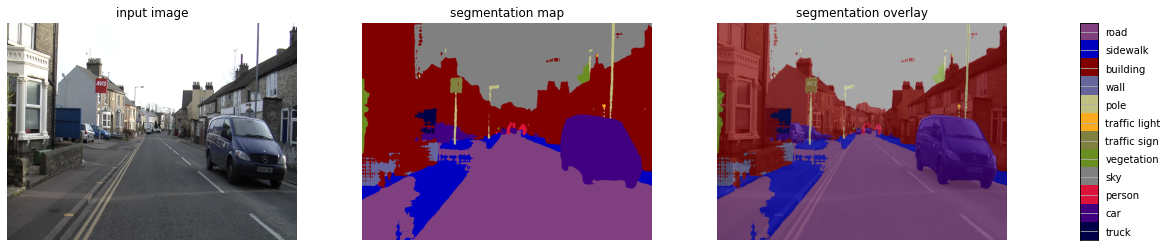

In [ ]:

def run_visualization(SAMPLE_IMAGE):
    """Inferences DeepLab model and visualizes result."""                                               #시각화 
    original_im = Image.open(SAMPLE_IMAGE)
    seg_map = MODEL.run(original_im)
    vis_segmentation(original_im, seg_map)


print('downloading the sample image...')
SAMPLE_IMAGE = urllib.request.urlretrieve('https://github.com/leesang100/Capstone2/blob/11fb1759575a20d40f90a01d3c0492c51f456cb5/data/Original_data/Seq05VD_f05100.png?raw=true')[0]
print('running deeplab on the sample image...')
run_visualization(SAMPLE_IMAGE)

In [ ]:
def vis_segmentation_stream(image, seg_map, index):
    """Visualizes segmentation overlay view and stream it with IPython display."""
    plt.figure(figsize=(12, 7))

    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay | frame #%d'%index)
    plt.grid('off')
    plt.tight_layout()

    # Show visualization in a streaming fashion.
    f = BytesIO()
    plt.savefig(f, format='jpeg')
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    f.close()
    plt.close()


def run_visualization_video(frame, index):
    """Inferences DeepLab model on a video file and stream the visualization."""
    original_im = Image.fromarray(frame[..., ::-1])
    seg_map = MODEL.run(original_im)
    vis_segmentation_stream(original_im, seg_map, index)




downloading the sample ground truth...
visualizing ground truth annotation on the sample image...


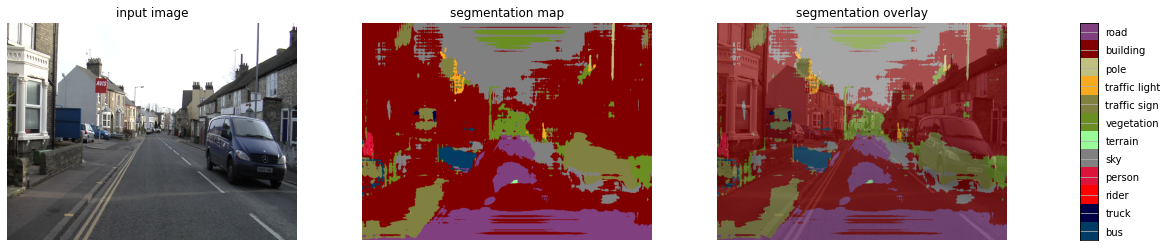

In [ ]:
import os
class DriveSeg(object):
    """Class to load MIT DriveSeg Dataset."""                                         # MIT Driveseg dataset 로드
                                                                                      # ground truth 학습하고자하는 데이터의 원본. annotation 주석
    def __init__(self, tarball_path):
        self.tar_file = tarfile.open(tarball_path)
        self.tar_info = self.tar_file.getmembers()
    
    def fetch(self, index):
        """Get ground truth by index.

        Args:
            index: The frame number.

        Returns:
            gt: Ground truth segmentation map.                                      
        """
        tar_info = self.tar_info[index + 1]  # exclude index 0 which is the parent directory
        file_handle = self.tar_file.extractfile(tar_info)
        gt = np.fromstring(file_handle.read(), np.uint8)
        gt = cv.imdecode(gt, cv.IMREAD_COLOR)
        gt = gt[:, :, 0]  # select a single channel from the 3-channel image
        gt[gt==255] = 19  # void class, does not count for accuracy
        return gt



SAMPLE_GT = 'mit_driveseg_sample_gt.tar.gz'
if not os.path.isfile(SAMPLE_GT): 
    print('downloading the sample ground truth...')
    #SAMPLE_GT = urllib.request.urlretrieve('https://github.com/lexfridman/mit-deep-learning/raw/master/tutorial_driving_scene_segmentatio/mit_driveseg_sample_gt.tar.gz')[0]
    SAMPLE_GT = urllib.request.urlretrieve('https://github.com/leesang100/Capstone2/blob/11fb1759575a20d40f90a01d3c0492c51f456cb5/data/Labeled_data/Seq05VD_f05100_L.png?raw=true')[0]
   

#dataset = DriveSeg(SAMPLE_GT)
print('visualizing ground truth annotation on the sample image...')

original_im = Image.open(SAMPLE_IMAGE)
#gt = dataset.fetch(0)  # sample image is frame 0
labeled_im = Image.open(SAMPLE_GT)
gt = MODEL.run(labeled_im)
vis_segmentation(original_im, gt)

In [ ]:
def evaluate_single(seg_map, ground_truth):
    """Evaluate a single frame with the MODEL loaded."""    
    # merge label due to different annotation scheme
    seg_map[np.logical_or(seg_map==14,seg_map==15)] = 13
    seg_map[np.logical_or(seg_map==3,seg_map==4)] = 2
    seg_map[seg_map==12] = 11

    # calculate accuracy on valid area
    acc = np.sum(seg_map[ground_truth!=19]==ground_truth[ground_truth!=19])/np.sum(ground_truth!=19)
    
    # select valid labels for evaluation
    cm = confusion_matrix(ground_truth[ground_truth!=19], seg_map[ground_truth!=19], 
                          labels=np.array([0,1,2,5,6,7,8,9,11,13]))
    intersection = np.diag(cm)
    union = np.sum(cm, 0) + np.sum(cm, 1)

    
    return acc, intersection, union

In [ ]:
print('evaluating on the sample image...')

SAMPLE_IMAGE = urllib.request.urlretrieve('https://github.com/leesang100/Capstone2/blob/11fb1759575a20d40f90a01d3c0492c51f456cb5/data/Original_data/Seq05VD_f05100.png?raw=true')[0]
original_im = Image.open(SAMPLE_IMAGE)
seg_map = MODEL.run(original_im)

#gt = dataset.fetch(0)  # sample image is frame 0
SAMPLE_GT = urllib.request.urlretrieve('https://github.com/leesang100/Capstone2/blob/11fb1759575a20d40f90a01d3c0492c51f456cb5/data/Labeled_data/Seq05VD_f05100_L.png?raw=true')[0]
labeled_im = Image.open(SAMPLE_GT)
gt = MODEL.run(labeled_im)

acc, intersection, union = evaluate_single(seg_map, gt)
class_iou = np.round(intersection / union, 5)

#print('pixel accuracy: %.5f'%acc)
print('mean class IoU:', np.mean(class_iou))
print('class IoU:')
print(tabulate([class_iou], headers=LABEL_NAMES[[0,1,2,5,6,7,8,9,11,13]]))

evaluating on the sample image...
mean class IoU: 0.09386900000000001
class IoU:
   road    sidewalk    building     pole    traffic light    traffic sign    vegetation    terrain    person    car
-------  ----------  ----------  -------  ---------------  --------------  ------------  ---------  --------  -----
0.29025           0     0.33526  0.25842                0         0.01063       0.04413          0         0      0


In [ ]:
SAMPLE_VIDEO = 'mit_driveseg_sample.mp4'
if not os.path.isfile(SAMPLE_VIDEO): 
    print('downloading the sample video...')
    SAMPLE_VIDEO = urllib.request.urlretrieve('https://github.com/lexfridman/mit-deep-learning/raw/master/tutorial_driving_scene_segmentation/mit_driveseg_sample.mp4')[0]
print('running deeplab on the sample video...')

video = cv.VideoCapture(SAMPLE_VIDEO)
# num_frames = 598  # uncomment to use the full sample video
num_frames = 30

try:
    for i in range(num_frames):
        _, frame = video.read()
        if not _: break
        run_visualization_video(frame, i)
        IPython.display.clear_output(wait=True)
except KeyboardInterrupt:
    plt.close()
    print("Stream stopped.")